# Анализ по проектным поставкам за 2024 год

## Импорт библиотек, загрузка и обработка файлов

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import NullLocator, LinearLocator, MultipleLocator, IndexLocator, FixedLocator
import random
from matplotlib.ticker import NullFormatter, FormatStrFormatter, FuncFormatter, ScalarFormatter
import matplotlib
from matplotlib.patches import ConnectionPatch

In [2]:
INPUT_PATH = os.getcwd() + "\\Входные данные"
OUTPUT_PATH = os.getcwd() + "\\Выходные данные"

In [3]:
# подгружаем необходимые данные для панализа
pyramid = pd.read_excel(INPUT_PATH + '\\Пирамида.xlsx')
projects = pd.read_excel(os.path.join(INPUT_PATH, 'Проекты.xlsx'))
projects = projects.rename(columns={'Заказ':'Номер заказа'})
fin_status = pd.read_excel(os.path.join(INPUT_PATH, 'Детальная_таблица_Финансового_блока.xlsx'))
abc_fmr = pd.read_excel(os.path.join(INPUT_PATH, 'ABC_FMR.xlsx'))
ptu = pd.read_excel(os.path.join(INPUT_PATH, 'ptu.xlsx'))
stats = pd.read_excel(os.path.join(INPUT_PATH, 'Stats.xlsx'))
scm = pd.read_excel(os.path.join(INPUT_PATH, 'SCM_report.xlsx'))
shipped_goods1 = pd.read_excel(INPUT_PATH + '\\Данные_по_РТиУ.xlsx', sheet_name='Данные по РТиУ')
shipped_goods2 = pd.read_excel(INPUT_PATH + '\\Данные_по_РТиУ.xlsx', sheet_name='Данные по РТиУ_1')
shipped_goods2 = pd.read_excel(INPUT_PATH + '\\Данные_по_РТиУ.xlsx', sheet_name='Данные по РТиУ_2')

C:\Users\SEA5324\AppData\Local\Programs\Python\Python312\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [7]:
# собираем несколько файлов из другого источника в один 18^36
files = os.listdir(os.path.join(os.getcwd(), 'Таблицы'))
dfs = []
for file_name in files:
    df = pd.read_excel(os.path.join(os.getcwd(), 'Таблицы', file_name))
    dfs.append(df)
df = pd.concat(dfs)
df = df[df['Отменено'] == 'Нет'] # убираем отмененки
df = df[~df['Номенклатура'].str.contains('слуг')]

# приведение форматов дат:
dates = ['Дата согласования','Дата отгрузки','Желаемая дата отгрузки', 'Контрактная дата отгрузки', 'Дата оформления документа']
for date in dates:
    df[date] = pd.to_datetime(df[date], format='%Y-%m-%d').dt.date

# обрабатываем данные из подгруженных таблиц:
df['Месяц согласования'] = df['Дата согласования'].apply(lambda x: x.strftime("%b")) # в сокр. буквенном формате для графиков
df['Месяц согласования2'] = df['Дата согласования'].apply(lambda x: x.strftime("%m")) # в числовом формате для более удобной сортировки 
project_orders = projects['Номер заказа'].unique()
projects_df = df[df['Номер заказа'].isin(project_orders)] # оставлем в выгрузке только проектные заказы
projects_df['Код строки'] = projects_df['Код строки'].astype(str)

shipped_goods1 = shipped_goods1[shipped_goods1['Реализация товаров и услуг.Пометка удаления'] == 'Нет']
shipped_goods2 = shipped_goods2[shipped_goods2['Реализация товаров и услуг.Пометка удаления'] == 'Нет']
shipped_goods = pd.concat([shipped_goods2,shipped_goods1])
shipped_goods = shipped_goods[~shipped_goods['Код строки'].isna()]
shipped_goods['Номер заказа'] = shipped_goods['Заказ клиента'].apply(lambda x: x[14:14+11])
shipped_goods['Код строки'] = shipped_goods['Код строки'].astype(int).astype(str)
shipped_goods['Дата отгрузки'] = shipped_goods['Реализация товаров и услуг'].apply(lambda x: x[42:52])
shipped_goods['Дата отгрузки'] = pd.to_datetime(shipped_goods['Дата отгрузки'], format='%d.%m.%Y').dt.date
shipped_goods = shipped_goods.sort_values(by='Дата отгрузки', ascending=False)
shipped_goods['Ключ'] = shipped_goods['Номер заказа'] + '&' + shipped_goods['Номенклатура.Артикул'] + '&' + shipped_goods['Код строки']
shipped_goods_for_shipment_dates = shipped_goods.drop_duplicates(subset='Ключ')

scm['Артикул&Склад'] = scm['Артикул'] + '&' + scm['Склад'] # ключ в SCM
suppliers = scm[~scm['Поставщик'].isna()][['Артикул','Поставщик']].drop_duplicates(subset='Артикул') # поставщики
whs_items = scm[~scm['Поставщик'].isna()][['Артикул','Складская номенклатура']].drop_duplicates(subset='Артикул') # MTS/MTO
delivery_time = scm[['Артикул&Склад', 'Срок поставки', 'Маршрут продолжительность']] # срок поставки
delivery_time = delivery_time[~delivery_time['Срок поставки'].isna()]
delivery_time = delivery_time.drop_duplicates(subset='Артикул&Склад')
scm['Статус продаж'] = scm[~scm['Статус продаж'].isna()]['Статус продаж'].apply(lambda x: x[:2]) 
scm['Статус закупок'] = scm[~scm['Статус закупок'].isna()]['Статус закупок'].apply(lambda x: x[:2])
material_status = scm[['Артикул&Склад', 'Статус продаж', 'Статус закупок']].drop_duplicates(subset='Артикул&Склад') # формируем таблицу с закупочным/сбытовым статусами

abc_fmr = abc_fmr[~abc_fmr['Склад'].isna()]
abc_fmr['Склад'] = abc_fmr['Склад'].apply(lambda x: x[:9])

# основные ключи:
scm['Склад'] = scm['Склад'].apply(lambda x: x[:9])
projects_df['Ключ'] = projects_df['Номер заказа'] + '&' + projects_df['Артикул'] + '&' + projects_df['Код строки']
projects_df['Артикул&Склад'] = projects_df['Артикул'] + '&' + projects_df['Склад']
fin_status['Фин_ключ'] = fin_status['Дата выгрузки данных о ФинБлоке'].astype(str) + '&' + fin_status['ИНН string'].astype(str) # для проверки фин блока
abc_fmr['Артикул&Склад'] = abc_fmr['Артикул'] + '&' + abc_fmr['Склад']

# подтянем все необходимые данные из SCM в projects_df
projects_df = projects_df.merge(pyramid[['Артикул', 'Business division','Business unit','Product Family', 'Product range']], on='Артикул', how='left')
projects_df = projects_df.merge(projects[['Проект', 'Проект.Завершен', 'Проект.Ответственный', 'Номер заказа']].drop_duplicates(subset='Номер заказа'), on='Номер заказа', how='left')
projects_df = projects_df.merge(suppliers, on='Артикул', how='left')
projects_df = projects_df.merge(whs_items, on='Артикул', how='left')
projects_df = projects_df.merge(material_status, on='Артикул&Склад', how='left')
projects_df = projects_df.merge(delivery_time, on='Артикул&Склад', how='left')
projects_df = projects_df.merge(abc_fmr[['Артикул&Склад', 'AMU (шт)']], on='Артикул&Склад', how='left')
# добавляем информацию по дате начала, завершения проекта, а также дата взятия в работу 
projects_df = projects_df.merge(stats[['Проект','Дата начала отслеживания','Дата первого заказа по проекту']], on='Проект', how='left')
# добавляем корректную дату отгрузки из файла РТУ
projects_df = projects_df.merge(shipped_goods_for_shipment_dates[['Ключ','Дата отгрузки']], suffixes=['_1C','_ПТУ'], on='Ключ', how='left')
#projects_df['Дата отгрузки скорр.'] = np.where(projects_df['Дата отгрузки_ПТУ'].isna(), projects_df['Дата отгрузки_1C'], projects_df['Дата отгрузки_ПТУ'])

C:\Users\SEA5324\AppData\Local\Temp\ipykernel_4272\2502222938.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  projects_df['Код строки'] = projects_df['Код строки'].astype(str)
C:\Users\SEA5324\AppData\Local\Temp\ipykernel_4272\2502222938.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  projects_df['Ключ'] = projects_df['Номер заказа'] + '&' + projects_df['Артикул'] + '&' + projects_df['Код строки']
C:\Users\SEA5324\AppData\Local\Temp\ipykernel_4272\2502222938.py:51: SettingWithCopyWarning: 
A value

## Общий анализ по проектам

**Общая стоимость проектов, RUB**

In [9]:
projects_sum = projects_df['Сумма'].sum().round(0)
projects_sum

546024.0

**Количество завершенных за год проектов**

In [10]:
projects_value = projects_df[projects_df['Проект.Завершен'] == 'Да']['Проект'].nunique()
projects_value

75

**На графиках ниже видно, что динамика проектных продаж не повторяет динамику продаж по компании в целом, а также видно характерные для проектной деятельности пики продаж в определененные месяцы**

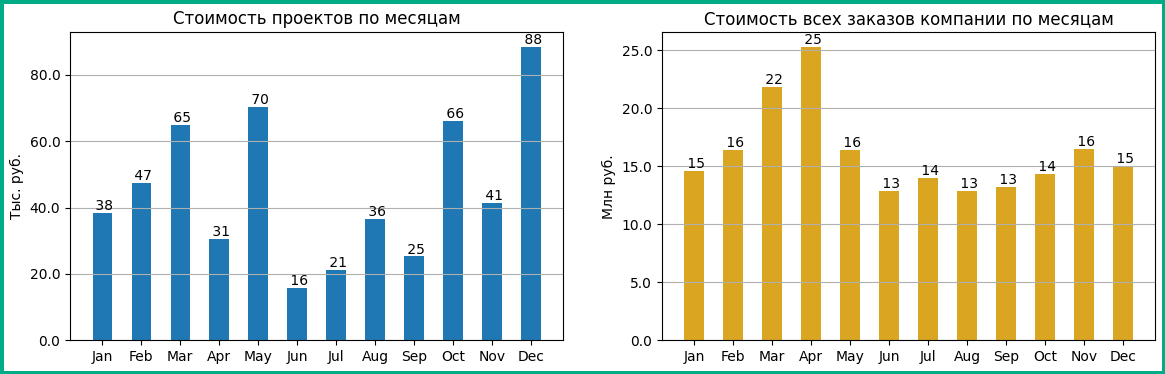

In [11]:
def func(y, pos):
    return y / 1000

def func2(y, pos):
    return y / 1000000

# стоимость проектов и заказов по месяцам
projects_total_by_month_pivot = pd.pivot_table(projects_df[['Месяц согласования', 'Месяц согласования2', 'Сумма']], index=['Месяц согласования', 'Месяц согласования2'], values='Сумма', aggfunc='sum').sort_values(by='Месяц согласования2')
orders_total_by_month_pivot = pd.pivot_table(df[['Месяц согласования', 'Месяц согласования2', 'Сумма']], index=['Месяц согласования', 'Месяц согласования2'], values='Сумма', aggfunc='sum').sort_values(by='Месяц согласования2')

fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax.yaxis.set_major_formatter(FuncFormatter(func))
ax2.yaxis.set_major_formatter(FuncFormatter(func2))
x = [i[0] for i in projects_total_by_month_pivot.index]
y = [i[0] for i in projects_total_by_month_pivot.values]
y2 = [i[0] for i in orders_total_by_month_pivot.values]
w = 0.5
ax.bar(x, y, width=w)

rects = ax.patches
rects2 = ax2.patches

# Make some labels.
labels = [f"{i / 1000: .0f}" for i in y]
labels2 = [f"{i / 1000000: .0f}" for i in y2]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

ax2.bar(x, y2, width=w, color='goldenrod')
for rect, label in zip(rects2, labels2):
    height = rect.get_height()
    ax2.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )
ax.set_title('Стоимость проектов по месяцам')
ax.set_ylabel('Тыс. руб.')
ax.grid(axis='y')
ax2.set_title('Стоимость всех заказов компании по месяцам')
ax2.set_ylabel('Млн руб.')
ax2.grid(axis='y')
fig.patch.set_linewidth(5)
fig.patch.set_edgecolor('#00ac86')

### В разрезе BU

**Маскировка данных**

In [14]:
# формальные названия для всех BU
BU_dict = {}
BU_list = projects_df['Business unit'].unique()
for i,j in enumerate(BU_list):
    BU_dict[j] = "Business unit_" + str(i) 
projects_df['Business unit'] = projects_df['Business unit'].apply(lambda x: BU_dict[x])

# формальные названия для всех PF
PF_list = projects_df['Product Family'].unique()
PF_dict = {}
for i,j in enumerate(PF_list):
    PF_dict[j] = "Product family_" + str(i) 
projects_df['Product Family'] = projects_df['Product Family'].apply(lambda x: PF_dict[x])

# формальные названия для всех артикулов
ref_list = projects_df['Артикул'].unique()
ref_dict = {}
for i,j in enumerate(ref_list):
    ref_dict[j] = "Референс_" + str(i) 
projects_df['Артикул'] = projects_df['Артикул'].apply(lambda x: ref_dict[x])

# формальные названия для всех поставщиков
suppliers_list = projects_df['Поставщик'].unique()
suppliers_dict = {}
for i,j in enumerate(suppliers_list):
    suppliers_dict[j] = "Поставщик_" + str(i) 
projects_df['Поставщик'] = projects_df['Поставщик'].apply(lambda x: suppliers_dict[x])

# формальные названия для всех поставщиков
client_list = projects_df['Наименование контрагента'].unique()
client_dict = {}
for i,j in enumerate(client_list):
    client_dict[j] = "Клиент_" + str(i) 
projects_df['Наименование контрагента'] = projects_df['Наименование контрагента'].apply(lambda x: client_dict[x])

In [16]:
# пивот ст-ти проектов в разрезе BU
BU_pivot_table = pd.pivot_table(projects_df[['Номер заказа','Сумма','Business unit']], index=['Business unit'], values=['Сумма','Номер заказа'], aggfunc={'Сумма': [np.sum, lambda x: sum(x) / sum(projects_df['Сумма'])], 'Номер заказа': pd.Series.nunique}).sort_values(by=('Сумма','sum'), ascending=False)
BU_pivot_table = BU_pivot_table.rename(columns={'Номер заказа':'Кол-во заказов', 'Сумма':'Сумма, RUB'})
BU_pivot_table.to_excel(os.path.join(os.getcwd(), 'Сводная по BU.xlsx'))
top_3_BU = BU_pivot_table['Сумма, RUB']['<lambda_0>'][:3] # топ 3 BU
rest_of_BU = BU_pivot_table['Сумма, RUB']['<lambda_0>'][3:]

C:\Users\SEA5324\AppData\Local\Temp\ipykernel_4272\933235299.py:2: FutureWarning: The provided callable <function sum at 0x0000018B629BB240> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  BU_pivot_table = pd.pivot_table(projects_df[['Номер заказа','Сумма','Business unit']], index=['Business unit'], values=['Сумма','Номер заказа'], aggfunc={'Сумма': [np.sum, lambda x: sum(x) / sum(projects_df['Сумма'])], 'Номер заказа': pd.Series.nunique}).sort_values(by=('Сумма','sum'), ascending=False)


**Визуализация разбивки стоимости проектов по BU**

posx and posy should be finite values
posx and posy should be finite values


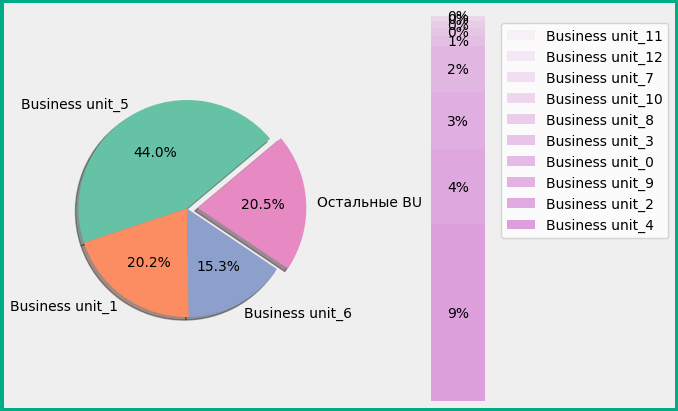

In [17]:
# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = [*top_3_BU.values, rest_of_BU.values.sum()]
labels = [*top_3_BU.index, 'Остальные BU']
explode = [0, 0, 0, 0.1]
# rotate so that first wedge is split by the x-axis
#angle = -360 * overall_ratios[3]
angle = 40
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode, colors=sns.color_palette("Set2"), shadow=True)

# bar chart parameters
age_ratios = rest_of_BU.values
age_labels = rest_of_BU.index
bottom = 1
width = .2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='plum', label=label,
                 alpha=0.1 + 1/len(rest_of_BU.index) * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.legend(bbox_to_anchor=(0.6, 0, 0.7, 1))
ax2.axis('off')
ax2.set_xlim(- 2.5 * width, 2.5 * width)

fig.patch.set_linewidth(5)
fig.patch.set_edgecolor('#00ac86')
fig.set_facecolor('#eeee')

plt.show()

### В разрезе BU и Product Family

In [18]:
# пивот стоимости проектов по BU & Product family
product_family_pivot = pd.pivot_table(projects_df[['Business unit', 'Product Family', 'Сумма', 'Количество']], index=['Business unit','Product Family'], values=['Сумма', 'Количество'], aggfunc='sum', margins=True).sort_values(by='Сумма').reset_index()
top_6_BU = BU_pivot_table['Сумма, RUB']['<lambda_0>'][:6] # топ 6 BU
after_6_BU = BU_pivot_table['Сумма, RUB']['<lambda_0>'][6:]

**Графики стоимости проектов по BU и Product family**

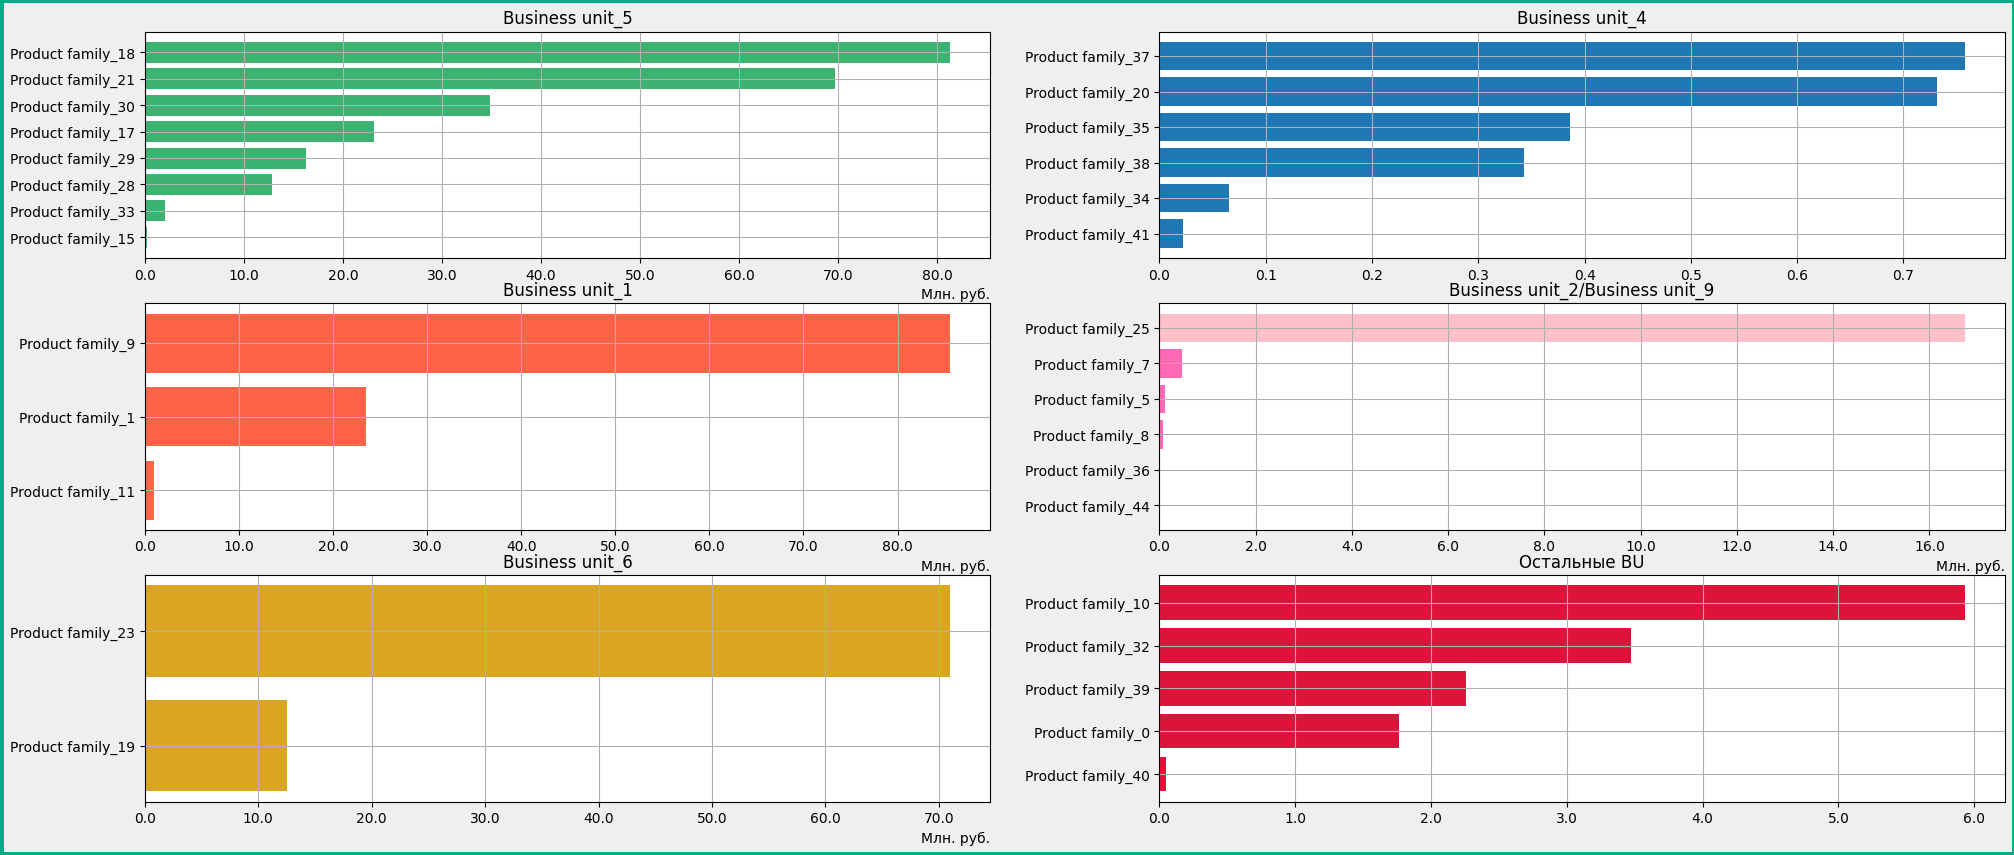

In [20]:
f, ax = plt.subplots(3,2)
f.set_size_inches(24,10)
f.set_facecolor('#eeee')
businesses = [*top_6_BU.index, 'Остальные BU']
ax[0,0].barh(product_family_pivot[(product_family_pivot['Business unit'] == businesses[0])]['Product Family'], product_family_pivot[(product_family_pivot['Business unit'] == businesses[0])]['Сумма'], color='mediumseagreen')
ax[0,0].xaxis.set_major_formatter(FuncFormatter(func))
ax[1,0].barh(product_family_pivot[(product_family_pivot['Business unit'] == businesses[1])]['Product Family'], product_family_pivot[(product_family_pivot['Business unit'] == businesses[1])]['Сумма'], color='tomato')
ax[1,0].xaxis.set_major_formatter(FuncFormatter(func))
ax[2,0].barh(product_family_pivot[product_family_pivot['Business unit'] == businesses[2]]['Product Family'], product_family_pivot[product_family_pivot['Business unit'] == businesses[2]]['Сумма'], color='goldenrod')
ax[2,0].xaxis.set_major_formatter(FuncFormatter(func))
ax[0,1].barh(product_family_pivot[(product_family_pivot['Business unit'] == businesses[3])]['Product Family'][:6], product_family_pivot[(product_family_pivot['Business unit'] == businesses[3])]['Сумма'][:6])
ax[0,1].xaxis.set_major_formatter(FuncFormatter(func))

ax[1,1].barh(product_family_pivot[product_family_pivot['Business unit'] == businesses[4]]['Product Family'][:5], product_family_pivot[product_family_pivot['Business unit'] == businesses[4]]['Сумма'][:5], color='hotpink')
ax[1,1].barh(product_family_pivot[product_family_pivot['Business unit'] == businesses[5]]['Product Family'], product_family_pivot[product_family_pivot['Business unit'] == businesses[5]]['Сумма'], color='pink')
ax[1,1].xaxis.set_major_formatter(FuncFormatter(func))

ax[2,1].barh(product_family_pivot[product_family_pivot['Business unit'] == after_6_BU.index[0]]['Product Family'], product_family_pivot[product_family_pivot['Business unit'] == after_6_BU.index[0]]['Сумма'], color='crimson')

ax[2,1].xaxis.set_major_formatter(FuncFormatter(func))

ax[0,0].grid(), ax[1,0].grid(), ax[2,0].grid(), ax[0,1].grid(), ax[1,1].grid(), ax[2,1].grid()
ax[0,0].set_title(businesses[0]), ax[1,0].set_title(businesses[1]), ax[2,0].set_title(businesses[2]), ax[0,1].set_title(businesses[3]), ax[1,1].set_title(f"{businesses[4]}/{businesses[5]}"), ax[2,1].set_title(businesses[-1])
ax[0,0].set_xlabel('Млн. руб.', loc='right'), ax[1,0].set_xlabel('Млн. руб.', loc='right'), ax[2,0].set_xlabel('Млн. руб.', loc='right'), ax[1,1].set_xlabel('Млн. руб.', loc='right')

f.patch.set_linewidth(5)
f.patch.set_edgecolor('#00ac86')

# Make some labels.
labels = list(map(int,product_family_pivot[(product_family_pivot['Business unit'] == businesses[0])]['Сумма']))
rects = ax[0,0].patches

**Cамые востребованные референсы по проектам**

In [22]:
most_in_demand_references = pd.pivot_table(projects_df[['Business unit', 'Артикул', 'Сумма', 'Количество']], index=['Business unit','Артикул'], values=['Сумма', 'Количество'], aggfunc={'Сумма':'sum', 'Количество':['count', 'sum']}).sort_values(by=('Количество', 'count'), ascending=False)
most_in_demand_references.to_excel(os.path.join(os.getcwd(), 'Most_demanded_refs.xlsx'))
most_in_demand_references.head(10)

Количество               Сумма
                                   count   sum           sum
Business unit   Артикул                                     
Business unit_5 Референс_1457        343  2014  34816.182751
                Референс_2481         85   104   1145.288676
                Референс_2479         64   169   2661.923613
Business unit_1 Референс_96           42  1581    284.176007
                Референс_1021         40  3015    697.903364
Business unit_5 Референс_1324         38  2702   1615.362933
Business unit_1 Референс_130          36  1909    130.540660
                Референс_1034         33  1098    420.822266
                Референс_187          32  4369    284.919858
                Референс_1020         30  1502    258.887413

**Топы проектов по показателям: стоимость, продолжительность, самые активные пользователи проектной логистики со стороны бизнеса**

In [23]:
top_projects_value = pd.pivot_table(projects_df[['Проект', 'Проект.Ответственный', 'Сумма']], index=['Проект', 'Проект.Ответственный'], values=['Сумма'], aggfunc='sum').sort_values(by='Сумма', ascending=False).to_excel(os.path.join(os.getcwd(), 'top_projects_value.xlsx'))
top_projects_managers = pd.pivot_table(projects_df[['Проект', 'Проект.Ответственный']], index=['Проект.Ответственный'], values=['Проект', 'Проект'], aggfunc=[pd.Series.nunique, lambda x: (', '.join(list(x.unique())))]).to_excel(os.path.join(os.getcwd(), 'top_projects_managers.xlsx'))

**Cтатистика по основным контрагентам в проектной логистике**

In [25]:
clients_pivot = pd.pivot_table(projects_df[['Наименование контрагента', 'Сумма']], index='Наименование контрагента', values='Сумма', aggfunc=[np.sum, lambda x: sum(x) / sum(projects_df['Сумма'])]).sort_values(by=('sum','Сумма'), ascending=False)
clients_pivot.to_excel(os.path.join(os.getcwd(), 'top_clients.xlsx'))
clients_pivot_small = pd.pivot_table(projects_df[['Наименование контрагента', 'Сумма']], index='Наименование контрагента', values='Сумма', aggfunc='sum').sort_values(by='Сумма', ascending=False)

C:\Users\SEA5324\AppData\Local\Temp\ipykernel_4272\1514178417.py:1: FutureWarning: The provided callable <function sum at 0x0000018B629BB240> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  clients_pivot = pd.pivot_table(projects_df[['Наименование контрагента', 'Сумма']], index='Наименование контрагента', values='Сумма', aggfunc=[np.sum, lambda x: sum(x) / sum(projects_df['Сумма'])]).sort_values(by=('sum','Сумма'), ascending=False)


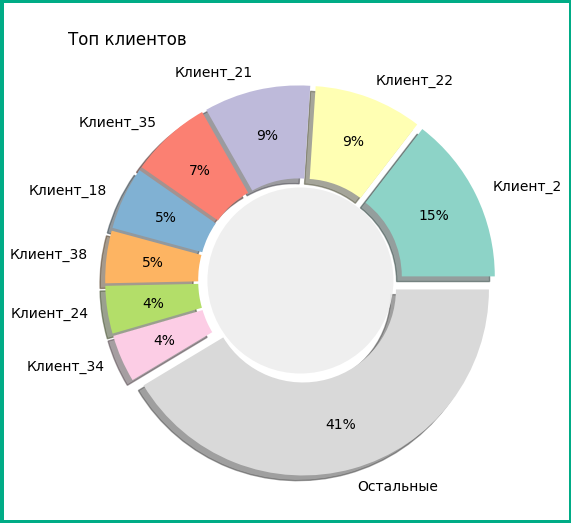

In [26]:
# визуализация
fig = plt.figure(figsize=(6,10))
ax = fig.add_subplot()

vals = [i[0] for i in clients_pivot_small.values[:8]]
vals.append((clients_pivot_small.values[8:].sum()))

labels = list(clients_pivot_small.index[:8])
labels.append('Остальные')

exp = (0.1, 0.2, 0, 0, 0, 0, 0, 0)
ax.pie(vals, labels=labels, autopct='%.0f%%', shadow=True, wedgeprops=dict(width=0.5), colors=sns.color_palette('Set3'), pctdistance=0.75, explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
hole = plt.Circle((0, 0), 0.5, facecolor='#eeee')
plt.gcf().gca().add_artist(hole)
fig.patch.set_linewidth(5)
fig.patch.set_edgecolor('#00ac86')
ax.set_title("\nТоп клиентов", loc='left', pad=2.0)
ax.grid()

In [27]:
suppliers_pivot = pd.pivot_table(projects_df[['Поставщик', 'Сумма']], index='Поставщик', values='Сумма', margins=True, aggfunc=[np.sum, lambda x: sum(x) / sum(projects_df['Сумма'])]).sort_values(by=('sum','Сумма'), ascending=False)
suppliers_pivot.to_excel(os.path.join(os.getcwd(), 'top_suppliers.xlsx'))
suppliers_pivot_small = pd.pivot_table(projects_df[['Поставщик', 'Сумма']], index='Поставщик', values='Сумма', aggfunc='sum').sort_values(by='Сумма', ascending=False)

C:\Users\SEA5324\AppData\Local\Temp\ipykernel_4272\550855725.py:1: FutureWarning: The provided callable <function sum at 0x0000018B629BB240> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  suppliers_pivot = pd.pivot_table(projects_df[['Поставщик', 'Сумма']], index='Поставщик', values='Сумма', margins=True, aggfunc=[np.sum, lambda x: sum(x) / sum(projects_df['Сумма'])]).sort_values(by=('sum','Сумма'), ascending=False)


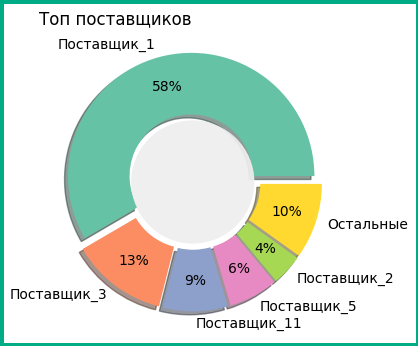

In [28]:
# визуализация
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot()

vals = [i[0] for i in suppliers_pivot_small.values[:5]]
vals.append((suppliers_pivot_small.values[5:].sum()))

labels = list(suppliers_pivot_small.index[:5])
labels.append('Остальные')

exp = (0.1, 0.2, 0, 0, 0)
ax.pie(vals, labels=labels, autopct='%.0f%%', shadow=True, wedgeprops=dict(width=0.5), colors=sns.color_palette('Set2'), pctdistance=0.75, explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05])
hole = plt.Circle((0, 0), 0.5, facecolor='#eeee')
plt.gcf().gca().add_artist(hole)
fig.patch.set_linewidth(5)
fig.patch.set_edgecolor('#00ac86')
ax.set_title("Топ поставщиков", loc='left', pad=2.0)
ax.grid()

# OTDS (on time delivery) - показатель уровня сервиса клиентам

## Общий OTDS

In [84]:
# словраь с показателем OTDS для общего OTDS и в разрезе BU
OTDs = {}

projects_df['Дата отгрузки скорр.'] = projects_df['Контрактная дата отгрузки'] + pd.to_timedelta([random.randint(-20,1) for i in range(len(projects_df['Контрактная дата отгрузки']))], unit='d')
projects_df.loc[projects_df['Складская номенклатура'] == 'Нет', 'Дата отгрузки скорр.'] = projects_df[projects_df['Складская номенклатура'] == 'Нет']['Контрактная дата отгрузки'] + pd.to_timedelta([random.randint(-1,1) for i in range(len(projects_df[projects_df['Складская номенклатура'] == 'Нет']['Контрактная дата отгрузки']))], unit='d')

# общий OTDS относительно контрактной даты:
projects_df.loc[projects_df['Дата отгрузки скорр.'] > projects_df['Контрактная дата отгрузки'], 'Вовремя отн. контр. даты'] = 0
projects_df.loc[projects_df['Дата отгрузки скорр.'] <= projects_df['Контрактная дата отгрузки'], 'Вовремя отн. контр. даты'] = 1 
gen_OTDS_required = round(len(projects_df[projects_df['Вовремя отн. контр. даты'] == 1]) / len(projects_df), 2)
gen_OTDS_mts_mat = round(len(projects_df[(projects_df['Складская номенклатура'] == 'Да') & (projects_df['Вовремя отн. контр. даты'] == 1)]) / len(projects_df[projects_df['Складская номенклатура'] == 'Да']), 2)
gen_OTDS_mto_mat = round(len(projects_df[(projects_df['Складская номенклатура'] == 'Нет') & (projects_df['Вовремя отн. контр. даты'] == 1)]) / len(projects_df[projects_df['Складская номенклатура'] == 'Нет']), 2)
OTDs['Общий'] = gen_OTDS_required
OTDs['Общий MTS'] = gen_OTDS_mts_mat
OTDs['Общий MTO'] = gen_OTDS_mto_mat

# посчитаем кол-во линий и стоимость в разрезе MTS/MTO
mts_lines = len(projects_df[(projects_df['Складская номенклатура'] == 'Да')])
mto_lines = len(projects_df[(projects_df['Складская номенклатура'] == 'Нет')])
total_lines = len(projects_df)

mts_value = sum(projects_df[(projects_df['Складская номенклатура'] == 'Да')]['Сумма'])
mto_value = sum(projects_df[(projects_df['Складская номенклатура'] == 'Нет')]['Сумма'])
total_value = sum(projects_df['Сумма'])

# сводник для общего OTDS по месяцам
otds_projects = pd.pivot_table(projects_df[['Месяц согласования','Месяц согласования2','Номер заказа','Вовремя отн. контр. даты']], index=['Месяц согласования', 'Месяц согласования2'], values='Вовремя отн. контр. даты', aggfunc=[lambda x: len(x), lambda x: len(x[x==1]), lambda x: len(x[x==1]) / len(x)]).sort_values(by='Месяц согласования2')

# сводники в разрезе MTS/MTO
otds_mts_mat = pd.pivot_table(projects_df[projects_df['Складская номенклатура'] == 'Да'][['Месяц согласования','Месяц согласования2','Номер заказа','Вовремя отн. контр. даты']], index=['Месяц согласования', 'Месяц согласования2'], values='Вовремя отн. контр. даты', aggfunc=[lambda x: len(x), lambda x: len(x[x==1]), lambda x: len(x[x==1]) / len(x)]).sort_values(by='Месяц согласования2')
otds_mto_mat = pd.pivot_table(projects_df[projects_df['Складская номенклатура'] == 'Нет'][['Месяц согласования','Месяц согласования2','Номер заказа','Вовремя отн. контр. даты']], index=['Месяц согласования', 'Месяц согласования2'], values='Вовремя отн. контр. даты', aggfunc=[lambda x: len(x), lambda x: len(x[x==1]), lambda x: len(x[x==1]) / len(x)]).sort_values(by='Месяц согласования2')

C:\Users\SEA5324\AppData\Local\Temp\ipykernel_4272\2571672039.py:4: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  projects_df['Дата отгрузки скорр.'] = projects_df['Контрактная дата отгрузки'] + pd.to_timedelta([random.randint(-20,1) for i in range(len(projects_df['Контрактная дата отгрузки']))], unit='d')
C:\Users\SEA5324\AppData\Local\Temp\ipykernel_4272\2571672039.py:5: PerformanceWarning: Adding/subtracting object-dtype array to TimedeltaArray not vectorized.
  projects_df.loc[projects_df['Складская номенклатура'] == 'Нет', 'Дата отгрузки скорр.'] = projects_df[projects_df['Складская номенклатура'] == 'Нет']['Контрактная дата отгрузки'] + pd.to_timedelta([random.randint(-1,1) for i in range(len(projects_df[projects_df['Складская номенклатура'] == 'Нет']['Контрактная дата отгрузки']))], unit='d')


**На графике ниже можно увидеть, что уровень сервиса по складским позициям в разрезе года выше, чем по заказным. Это может свидетельствовать о хорошем прогнозировании и планировании отделами снабжения и продуктового маркетинга, но также и сигнализировать о слишком высоком уровне склада и/или низком уровне продаж**

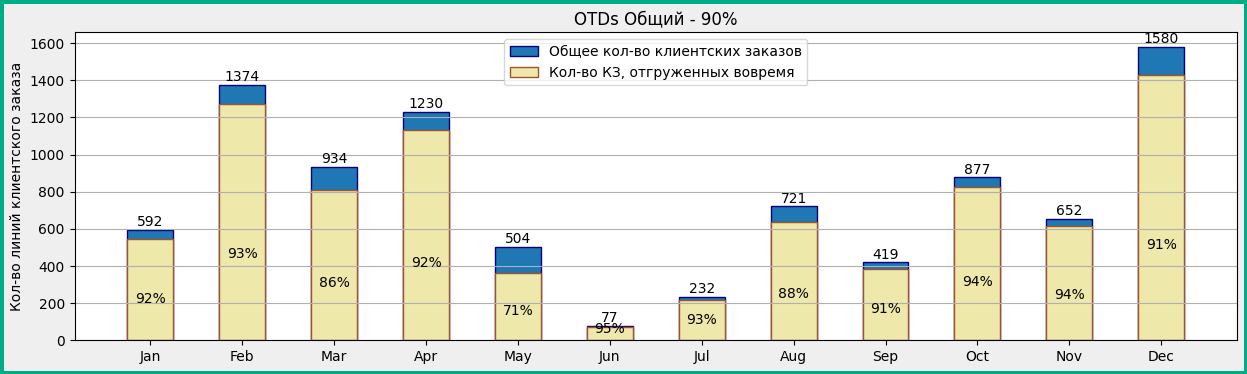

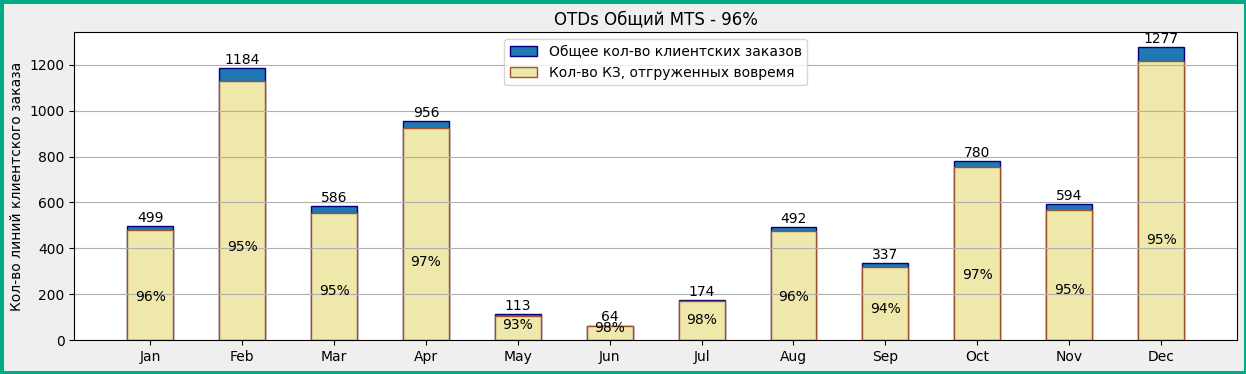

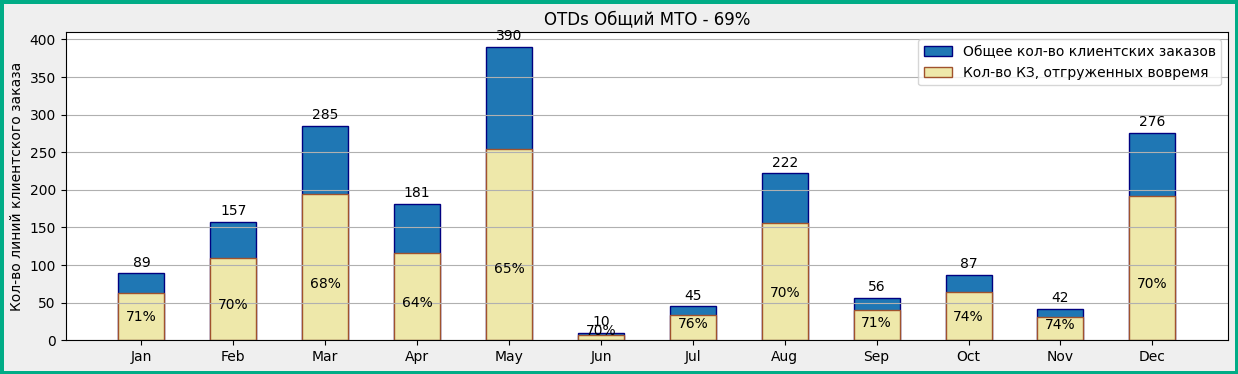

In [85]:
# график для общего OTDS по месяцам (все рефы, mts, mto)
refs_groups = [otds_projects, otds_mts_mat, otds_mto_mat]
titles = ['Общий', 'Общий MTS', 'Общий MTO']
i = 0

for ref_group in refs_groups:
    fig = plt.figure(figsize=(15,4))
    fig.set_facecolor('#eeee')
    ax = fig.add_subplot()
    f.set_size_inches(34,34)
    f.set_facecolor('#eeee')
    x = [i[0] for i in ref_group.index]
    y = [i[0] for i in ref_group.values]
    y2 = [i[1] for i in ref_group.values]
    y3 = [i[2] for i in ref_group.values]
    X_axis = np.arange(len(x))
    w = 0.5
    ax.bar(X_axis, y, width=w, label='Общее кол-во клиентских заказов', edgecolor='navy')
    ax.bar(X_axis, y2, width=w, label='Кол-во КЗ, отгруженных вовремя', edgecolor='sienna', color='palegoldenrod')
    ax.grid(axis='y')
    ax.legend()
    ax.set_title(f'OTDs {titles[i]} - {int(OTDs[titles[i]] * 100)}%')
    i += 1
    ax.set_ylabel('Кол-во линий клиентского заказа')
    plt.xticks(X_axis, x)
    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('#00ac86')
    
    rects = ax.patches
    rects2 = ax.patches
    rects3 = ax.patches
    
    # Make some labels.
    labels = list(map(int,y))
    labels2 = list(map(int,y2))
    labels3 = [f"{int(round(i * 100))}%" for i in y3]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
        )
    j = 0
    for rect, label in zip(rects3, labels3):
        height = (labels[j] * y3[j]) / 3
        j += 1
        ax.text(
            rect.get_x() + rect.get_width() / 2, height + 1, label, ha="center", va="bottom"
        )

## OTDS в разрезе BU

In [86]:
# пивот в разрезе BU
otds_projects_BU = pd.pivot_table(projects_df[['Месяц согласования','Месяц согласования2','Номер заказа','Вовремя отн. контр. даты', 'Business unit']], index=['Business unit', 'Месяц согласования', 'Месяц согласования2'], values='Вовремя отн. контр. даты', aggfunc=[lambda x: len(x), lambda x: len(x[x==1]), lambda x: len(x[x==1]) / len(x)]).sort_values(by='Месяц согласования2').reset_index()

# основные BU по проектам
businesses = ['Business unit_4', 'Business unit_1', 'Business unit_2', 'Business unit_5']

# посчитаем для них OTDS
for business in businesses:
    total_lines_power = sum([i[3] for i in otds_projects_BU[otds_projects_BU['Business unit'] == business].values])
    on_time_lines_power = sum([i[4] for i in otds_projects_BU[otds_projects_BU['Business unit'] == business].values])
    bu_OTDS = {}
    OTDs[business] = bu_OTDS
    bu_OTDS['Общий'] = round(on_time_lines_power / total_lines_power, 2)

C:\Users\SEA5324\AppData\Local\Temp\ipykernel_4272\954747698.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  otds_projects_BU = pd.pivot_table(projects_df[['Месяц согласования','Месяц согласования2','Номер заказа','Вовремя отн. контр. даты', 'Business unit']], index=['Business unit', 'Месяц согласования', 'Месяц согласования2'], values='Вовремя отн. контр. даты', aggfunc=[lambda x: len(x), lambda x: len(x[x==1]), lambda x: len(x[x==1]) / len(x)]).sort_values(by='Месяц согласования2').reset_index()
C:\Users\SEA5324\AppData\Local\Temp\ipykernel_4272\954747698.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  otds_projects_BU = pd.pivot_table(projects_df[['Месяц согласования','Месяц согласования2','Номер заказа','Вовремя отн. контр. даты', 'Business unit']], index=['Business unit', 'Месяц согласования', 'Месяц согласования2'], values='Вовремя отн. контр. даты', aggfunc=[lambda x: len(x), lambda x: len(x[x==1]), lambda x: len(x[

**На графике OTDS в разрезе BU ниже можем увидеть, что у бизнесов 4 и 5 OTDS ниже, т.к. это проектные бизнесы с более высоким процентом заказных позиций:**

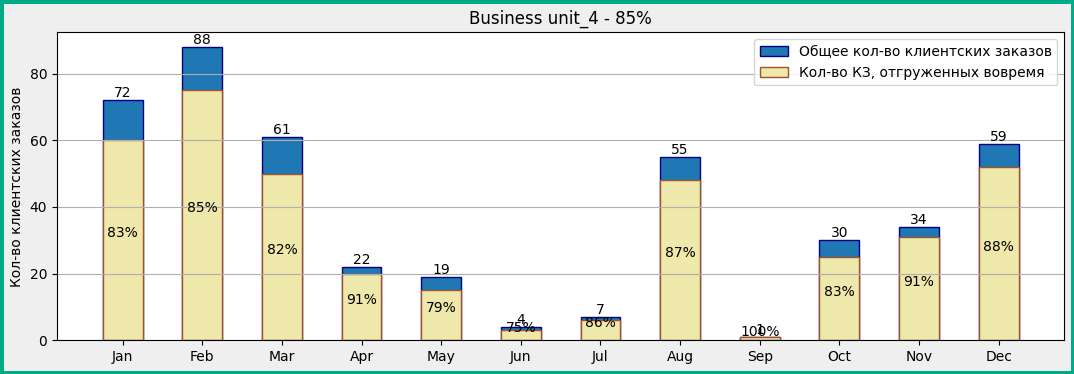

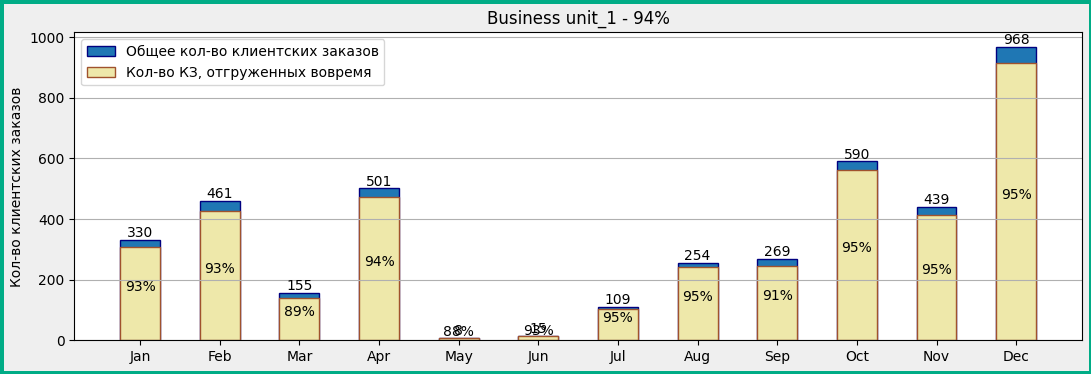

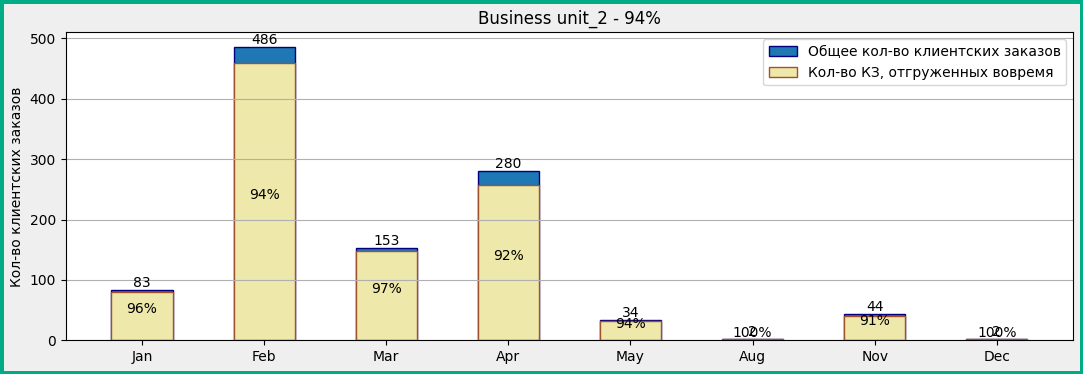

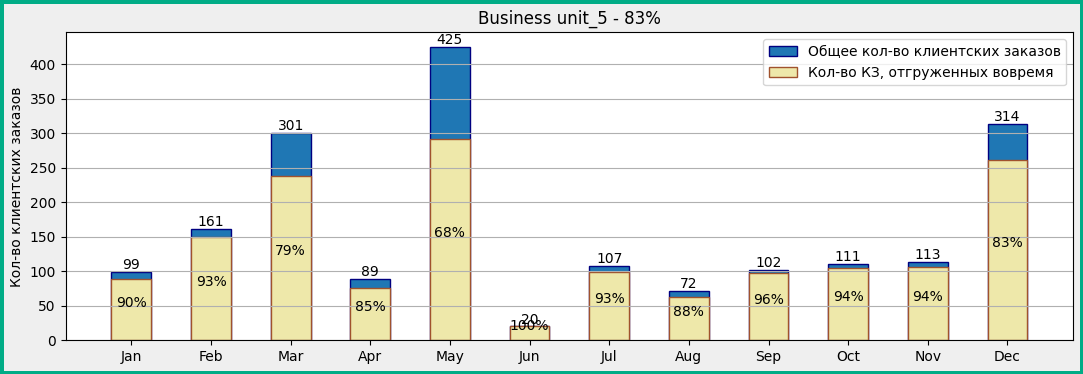

In [95]:
# нарисуем графики под OTDS в разрезе каждого BU
for business in businesses:
    fig = plt.figure(figsize=(13,4))
    fig.set_facecolor('#eeee')
    ax = fig.add_subplot()
    f.set_size_inches(34,34)
    f.set_facecolor('#eeee')
    x = otds_projects_BU[otds_projects_BU['Business unit'] == business]['Месяц согласования'].values
    y = [i[3] for i in otds_projects_BU[otds_projects_BU['Business unit'] == business].values]
    y2 = [i[4] for i in otds_projects_BU[otds_projects_BU['Business unit'] == business].values]
    y3 = [i[5] for i in otds_projects_BU[otds_projects_BU['Business unit'] == business].values]
    X_axis = np.arange(len(x))
    w = 0.5
    ax.bar(X_axis, y, width=w, label='Общее кол-во клиентских заказов', edgecolor='navy')
    ax.bar(X_axis, y2, width=w, label='Кол-во КЗ, отгруженных вовремя', edgecolor='sienna', color='palegoldenrod')
    ax.grid(axis='y')
    ax.legend()
    ax.set_title(f'{business} - {int(OTDs[business]['Общий'] * 100)}%')
    ax.set_ylabel('Кол-во клиентских заказов')
    plt.xticks(X_axis, x)
    fig.patch.set_linewidth(5)
    fig.patch.set_edgecolor('#00ac86')
    
    rects = ax.patches
    
    labels = list(map(int,y))
    labels3 = [f"{int(round(i * 100))}%" for i in y3]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        ) 
    
    j = 0
    for rect, label in zip(rects, labels3):
        height = (labels[j] * y3[j]) / 2
        j += 1
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha="center", va="bottom"
        )

# RCA (root cost analysis)

## Алгоритм определения причин задержек

![Алгоритм определения причины](RCA.jpg)

In [97]:
# возможные причины задержки
projects_df['Отложенная дата клиента'] = 0
projects_df['Фин блок'] = 0
projects_df['Другие проблемы с отгрузкой клиенту'] = 0
projects_df['Нехватка стока (для MTS)'] = 0
projects_df['Elephant order'] = 0
projects_df['Задержка отгрузки от поставщика'] = 0
projects_df['Задержка транспортировки'] = 0
projects_df['Задержка при размещении РО'] = 0

In [98]:
# ПРИЧИНА ОТЛОЖЕННАЯ ДАТА КЛИЕНТА
projects_df.loc[(projects_df['Вовремя отн. контр. даты'] == 0) & (projects_df['Желаемая дата отгрузки'] > projects_df['Дата отгрузки скорр.']), 'Отложенная дата клиента'] = 1

In [ ]:
# загрузим наличие на складах на известные даты
whs_with_delays = projects_df.loc[(projects_df['Вовремя отн. контр. даты'] == 0)]['Склад'].unique() # склады, с которых отгружались проектные материалы с задержкой
materials_with_delays = projects_df.loc[(projects_df['Вовремя отн. контр. даты'] == 0)]['Артикул'].unique() # проектные материалы с задержкой

monthly_stock_paths = []
for folder_name in os.listdir(daily_stock):
    path = os.path.join(daily_stock, folder_name)
    if '2023' not in path:
        monthly_stock_paths.append(path)

daily_stock_dfs = []
for one_month_path in monthly_stock_paths:
    # проваливаемся внутрь этой папки 
    for file_name in os.listdir(one_month_path):
        
        if 'Выгрузка' in file_name and '~' not in file_name:
            try:
                date = pd.to_datetime(pd.to_datetime(file_name[-13:-5], format='%d%m%Y'))
                one_day_stock_df = pd.read_excel(os.path.join(one_month_path, file_name))
                one_day_stock_df = one_day_stock_df[~one_day_stock_df['Склад'].isna()]
                one_day_stock_df['Склад'] = one_day_stock_df['Склад'].apply(lambda x: x[:9])
                one_day_stock_df = one_day_stock_df[(one_day_stock_df['Артикул'].isin(materials_with_delays)) & (one_day_stock_df['Склад'].isin(whs_with_delays))][['Дата выгрузки','Артикул','Склад', 'Доступно', 'К обеспечению']].fillna(0)
                daily_stock_dfs.append(one_day_stock_df)
            except ValueError:
                continue
            except OSError:
                continue

daily_stock_df = pd.concat(daily_stock_dfs)
daily_stock_df['Дата выгрузки'] = pd.to_datetime(daily_stock_df['Дата выгрузки'], format='%Y-%m-%d').dt.date
daily_stock_df_copy = daily_stock_df[:]
daily_stock_df.to_excel(os.path.join(OUTPUT_PATH, 'остатки на складах за год.xlsx'))

In [114]:
# вс - 6 (то -2)
# сб - 5 (то -1)
def condition(x):
    if x.weekday() == 6:
        return x - pd.to_timedelta(2, unit='d')
    elif x.weekday() == 5:
        return x - pd.to_timedelta(1, unit='d')
    else:
        return x

In [115]:
# критическая дата отгрузки - 2 дня = дата, когда товар должен быть в наличии на складе. Найдем эту дату
projects_df['Дата наличия на складе'] = projects_df['Дата отгрузки скорр.'] - pd.to_timedelta(2, unit='d')
projects_df['Дата наличия на складе'] = projects_df['Дата наличия на складе'].apply(condition)
projects_df['Дата наличия на складе2'] = projects_df['Дата отгрузки скорр.'] - pd.to_timedelta(1, unit='d')
projects_df['Дата наличия на складе2'] = projects_df['Дата наличия на складе2'].apply(condition)

# создаем ключи, чтобы в таблицы с проектами подтянуть сток на дату за 2 дня до отгрузки и за 1 день
daily_stock_df['Ключ_daily_stock'] = daily_stock_df['Артикул'] + '&' + daily_stock_df['Дата выгрузки'].astype(str) + '&' + daily_stock_df['Склад']
projects_df['Ключ_daily_stock'] = projects_df['Артикул'] + '&' + projects_df['Дата наличия на складе'].astype(str) + '&' + projects_df['Склад']
daily_stock_df['Ключ_daily_stock_2'] = daily_stock_df['Артикул'] + '&' + daily_stock_df['Дата выгрузки'].astype(str) + '&' + daily_stock_df['Склад']
projects_df['Ключ_daily_stock_2'] = projects_df['Артикул'] + '&' + projects_df['Дата наличия на складе2'].astype(str) + '&' + projects_df['Склад']

projects_df = projects_df.merge(daily_stock_df[['Ключ_daily_stock','Доступно']], on='Ключ_daily_stock', how='left')
projects_df = projects_df.merge(daily_stock_df[['Ключ_daily_stock_2','Доступно']], on='Ключ_daily_stock_2', how='left')

projects_df['Наличие на складе'] = np.where(projects_df['Доступно_x'].isna(), projects_df['Доступно_y'], projects_df['Доступно_x'])
projects_df = projects_df.rename(columns={'Доступно_x':'Доступно на складе за 2 дня до отгрузки', 'Доступно_y':'Доступно на складе за 1 день до отгрузки'})

In [116]:
# ПРИЧИНА ФИНАНСОВЫЙ БЛОК
projects_df['Фин_ключ'] = projects_df['Дата наличия на складе'].astype(str) + '&' + projects_df['ИНН контрагента'].astype(str)
projects_df = projects_df.merge(fin_status[['Фин_ключ','Риск категория контрагента']], on='Фин_ключ', how='left')
projects_df.loc[(projects_df['Вовремя отн. контр. даты'] == 0) & (~projects_df['Дата отгрузки_ПТУ'].isna()) & (~projects_df['Риск категория контрагента'].isna()), 'Фин блок'] = 1

In [117]:
# ПОЗИЦИЯ БЫЛА НА СТОКЕ ЗА 2 ДНЯ ДО КОНТРАКТНОЙ ДАТЫ, НО ПОЧЕМУ-ТО НЕ ОТГРУЗИЛАСЬ
projects_df.loc[(projects_df['Вовремя отн. контр. даты'] == 0) & (~projects_df['Дата отгрузки_ПТУ'].isna()) & (projects_df['Количество'] <= projects_df['Наличие на складе']) & (projects_df['Риск категория контрагента'].isna()), 'Другие проблемы с отгрузкой клиенту'] = 1

# ПРИЧИНА КАЛЕНДАРЬ ОТГРУЗОК
projects_df.loc[(projects_df['Другие проблемы с отгрузкой клиенту'] == 1) & ((projects_df['Дата отгрузки скорр.'] - projects_df['Контрактная дата отгрузки']) <= pd.to_timedelta(4, unit='d')), 'Календарь отгрузок'] = 1

# ПРИЧИНА НЕХВАТКА СТОКА (ДЛЯ MTS)
projects_df.loc[(projects_df['Вовремя отн. контр. даты'] == 0) & (projects_df['Складская номенклатура'] == 'Да') & (~projects_df['Дата отгрузки_ПТУ'].isna()) & (projects_df['Количество'] > projects_df['Наличие на складе']), 'Нехватка стока (для MTS)'] = 1

# ELEPHANT ORDERS
projects_df.loc[(projects_df['Нехватка стока (для MTS)'] == 1) & (projects_df['Количество'] > projects_df['AMU (шт)']), 'Elephant order'] = 1

In [123]:
# АНАЛИЗИРУЕМ ЗАКАЗЫ МТО

# обработка файла ПТУ
ptu = ptu[~ptu['Приобретение товаров и услуг.Дата'].isna()]
ptu['Приобретение товаров и услуг.Дата'] = ptu['Приобретение товаров и услуг.Дата'].apply(lambda x: x[:10])
ptu['Приобретение товаров и услуг.Дата'] = pd.to_datetime(ptu['Приобретение товаров и услуг.Дата'], format='%d.%m.%Y').dt.date

ptu.loc[~ptu['Приобретение товаров и услуг.Дата поступления'].isna(), 'Приобретение товаров и услуг.Дата поступления'] = ptu.loc[~ptu['Приобретение товаров и услуг.Дата поступления'].isna(), 'Приобретение товаров и услуг.Дата поступления'].apply(lambda x: x[:10])
ptu.loc[~ptu['Приобретение товаров и услуг.Дата поступления'].isna(), 'Приобретение товаров и услуг.Дата поступления'] = pd.to_datetime(ptu.loc[~ptu['Приобретение товаров и услуг.Дата поступления'].isna(), 'Приобретение товаров и услуг.Дата поступления'], format='%d.%m.%Y', errors = 'coerce').dt.date

ptu = ptu.sort_values(['Номенклатура.Артикул','Приобретение товаров и услуг.Дата поступления'], ascending=[True, False])
ptu = ptu[~ptu['Склад'].isna()]
ptu['Склад'] = ptu['Склад'].apply(lambda x: x[:9])
ptu = ptu[ptu['Склад'].isin(['RU01-4000', 'RU01-5600', 'RU06-4000', 'RU01-5699', 'RU40-5000'])]
ptu['Артикул&Склад'] = ptu['Номенклатура.Артикул'] + '&' + ptu['Склад']

In [ ]:
# если оборудования не было на складе для своевременной отгрузки (условно за 2 дня до даты отгрузки), значит это кол-во было обеспечено позже ПТУ с 
# максимально близкой датой поступления на склад к дате отгрузки по клиентскому заказу 
# Методом простого перебора всех ПТУ по этому референсу подбирается максимально подходящее (по дате прихода и кол-ву) ПТУ для покрытия клиентского заказа

projects_df.sort_values(['Артикул', 'Дата отгрузки скорр.'], ascending=[True, True], inplace=True)

for index, row in projects_df.iterrows():

    sub_ptu = ptu[ptu['Артикул&Склад'] == row['Артикул&Склад']] # all arrival dates for this item & whs combination
    temp_sum = 0
    
    for i,r in sub_ptu.iterrows():
        try:
            if r['Приобретение товаров и услуг.Дата поступления'] + pd.to_timedelta(4, unit='d') <= row['Дата отгрузки скорр.']:
                print("Date is less")
                print(r['Приобретение товаров и услуг.Дата поступления'])
                # проверяем, хватает ли по кол-ву в одной строке ПТУ
                
                if temp_sum + r['Количество (в единицах хранения)'] >= row['Количество']:
                    # забираем эти строки (сколько?)
    
                    # забираю строку
                    projects_df.loc[index, 'Номер ПТУ'] = r['Приобретение товаров и услуг.Номер']
                    projects_df.loc[index, 'Дата создания ПТУ'] = r['Приобретение товаров и услуг.Дата']
                    projects_df.loc[index, 'Дата поступления ПТУ'] = r['Приобретение товаров и услуг.Дата поступления']
                    projects_df.loc[index, 'Заказ поставщику'] = r['Заказ поставщику']
                    projects_df.loc[index, 'Кол-во по ПТУ'] = r['Количество (в единицах хранения)'] + temp_sum
                    
                    # уменьшаю остаток 
                    ptu.loc[i, 'Количество (в единицах хранения)'] -= row['Количество'] #чтобы больше ими нельзя было пользоваться
                    break 
                    
                else:
                    # обнуляю остаток
                    ptu.loc[i, 'Количество (в единицах хранения)'] = 0
                    temp_sum += r['Количество (в единицах хранения)']

        except TypeError as error:
            continue
                               

In [141]:
projects_df = projects_df.merge(delivery_time[['Артикул&Склад', 'Срок поставки', 'Маршрут продолжительность']], on='Артикул&Склад', how='left')

# дата РО
projects_df.loc[~(projects_df['Заказ поставщику'] == 'nan'), 'Дата РО'] = projects_df[~(projects_df['Заказ поставщику'] == 'nan')]['Заказ поставщику'].apply(lambda x: x[32:42])
projects_df['Дата РО'] = pd.to_datetime(projects_df['Дата РО'], format='%d.%m.%Y')

# ЗАДЕРЖКА ОТГРУЗКИ ОТ ПОСТАВЩИКА
projects_df.loc[(projects_df['Дата РО'] + pd.to_timedelta(projects_df['Срок поставки'] + 7, unit='d') < projects_df['Дата отгрузки скорр.']) & (projects_df['Вовремя отн. контр. даты'] == 0), 'Задержка отгрузки от поставщика'] = 1

In [147]:
projects_df['Дата создания ПТУ'] = pd.to_datetime(projects_df['Дата создания ПТУ'], format='%Y-%m-%d')
# ЗАДЕРЖКА ТРАНСПОРТИРОВКИ
projects_df.loc[(projects_df['Дата создания ПТУ'] + pd.to_timedelta(projects_df['Маршрут продолжительность'], unit='d')) > projects_df['Дата поступления ПТУ'], 'Задержка транспортировки'] = 1

In [148]:
# ВОЗМОЖНАЯ ЗАДЕРЖКА ПРИ РАЗМЕЩЕНИИ РО
projects_df.loc[(projects_df['Дата согласования'] + pd.to_timedelta(7, unit='d')) < projects_df['Дата РО'], 'Задержка при размещении РО'] = 1

## Итоги

In [149]:
reasons = ['Отложенная дата клиента', 'Фин блок', 'Другие проблемы с отгрузкой клиенту', 'Нехватка стока (для MTS)', 'Elephant order', 'Задержка отгрузки от поставщика', 'Задержка транспортировки', 'Задержка при размещении РО']
reasons_dict = {}
projects_df['Сумма баллов'] = projects_df['Отложенная дата клиента'] + projects_df['Фин блок'] + projects_df['Другие проблемы с отгрузкой клиенту'] + projects_df['Нехватка стока (для MTS)'] + projects_df['Нехватка стока (для MTS)/Elephant order'] + projects_df['Задержка отгрузки от поставщика'] + projects_df['Задержка транспортировки'] + projects_df['Задержка при размещении РО'] 
i = 0
for reason in reasons:
    reasons_dict[reason] = sum(projects_df[projects_df['Вовремя отн. контр. даты'] == 0][reasons[i]])
    i += 1

**Итого RCA анализ показал, что наиболее распространенными причинами задержки поставок по проектам являются задержка отгрузки от поставщика и задержка транспортировки** 

In [153]:
reasons_dict

{'Отложенная дата клиента': 56,
 'Фин блок': 0,
 'Другие проблемы с отгрузкой клиенту': 0,
 'Нехватка стока (для MTS)': 0,
 'Elephant order': 0,
 'Задержка отгрузки от поставщика': 371,
 'Задержка транспортировки': 254,
 'Задержка при размещении РО': 46}

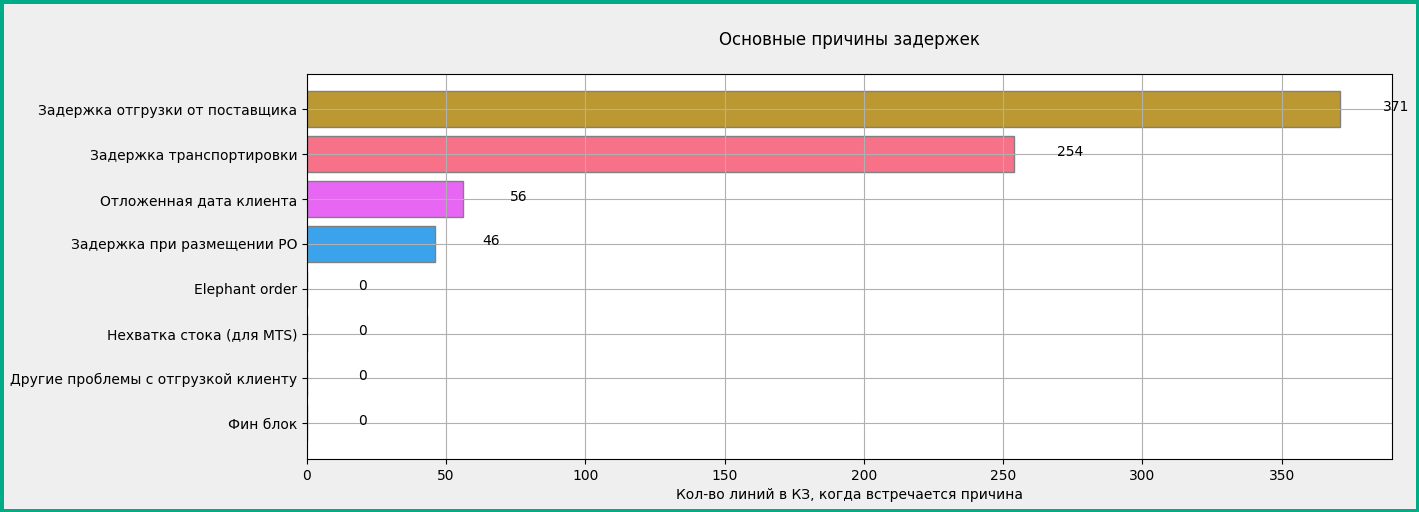

In [156]:
# графики стоимости проектов по BU и Product family
fig = plt.figure(figsize=(14,5))
fig.set_facecolor('#eeee')
ax = fig.add_subplot()
f.set_size_inches(34,34)

x = list(dict(sorted(reasons_dict.items(), key=lambda item: item[1])).keys())
y = list(dict(sorted(reasons_dict.items(), key=lambda item: item[1])).values())

ax.barh(x, y, color=sns.color_palette('husl'), edgecolor='grey')

fig.patch.set_linewidth(5)
fig.patch.set_edgecolor('#00ac86')
ax.grid()

rects = ax.patches
ax.set_xlabel('Кол-во линий в КЗ, когда встречается причина')
ax.set_title("\nОсновные причины задержек\n")

for rect, label in zip(rects, y):
    width = rect.get_width()
    height = rect.get_height()
    ax.text(
        width + 20, rect.get_y() + rect.get_height() - 0.5, label, ha="center", va="bottom"
    ) 